# SIGMA \begin{equation*} \frac{\partial V}{\partial t} = \Psi + \Omega_{surf} + R_{diff,R2} \end{equation*}
## **SODA 3.4.2**

In [22]:
from dask_gateway import GatewayCluster

cluster = GatewayCluster()
cluster.scale(30)
#cluster.adapt(minimum=2, maximum=10)  # or cluster.scale(n) to a fixed size.
client = cluster.get_client()

In [23]:
client

Client Scheduler: gateway://traefik-gcp-uscentral1b-staging-dask-gateway.staging:80/staging.02c8e136d44a4f55ae69bb8a9e8c5bb9 Dashboard: /services/dask-gateway/clusters/staging.02c8e136d44a4f55ae69bb8a9e8c5bb9/status,Cluster Workers: 10 Cores: 20 Memory: 80.00 GiB


In [97]:
client.close()
cluster.close()

In [1]:
import xarray as xr
import pandas as pd
from matplotlib import pyplot as plt
import gcsfs
import dask
import dask.array as dsa
import numpy as np
import fsspec
import xmitgcm
import xgcm
from xhistogram.xarray import histogram
from fastjmd95 import jmd95numba
import fastjmd95
xr.set_options(display_style='text');

In [2]:
url_ocean = 'gs://pangeo-forge-us-central1/pangeo-forge/soda/soda3.4.2_5dy_ocean_or'
fs = gcsfs.GCSFileSystem()
ocean = xr.open_zarr(fs.get_mapper(url_ocean), consolidated=True, decode_times=False)

In [3]:
#fix time dim (1898/1897 indices are 1980-01-01)
test_time = xr.cftime_range('1993-01-04 13:00:00', freq='5D', periods=1970, calendar='julian')
ocean_test = ocean.copy()
ocean_test = ocean.assign_coords(coords={'time': test_time})
#ocean_test = ocean.assign_attrs(ocean.time.attrs)
ocean['time'] = ocean_test.time

In [4]:
path = 'pangeo-tmp/stb2145/SODA/datasets/'

transport = xr.open_zarr(gcsfs.GCSMap(path + 'transport_wg.zarr'))
cells = xr.open_zarr(gcsfs.GCSMap(path + 'cells_wg.zarr'))
surf = xr.open_zarr(gcsfs.GCSMap(path + 'surf_terms.zarr'))
totend = xr.open_zarr(gcsfs.GCSMap(path + 'totend.zarr'))

## <font color='Green'>Slice to WG region</font>

In [5]:
#WG boundaries (80˚S, 62˚S, 65˚W, 30˚E)
lower_lat = 0 #-80.02101494
upper_lat = 169 #-62.01972704
left_lon =  859 #-65.12
right_lon = 1240 #30.12

lower_lat_u = 0 #-79.96821565
upper_lat_u = 169 #-61.96096874 python is right exclusive so will have -62.0 in array
left_lon_u = 859 #-65.0
right_lon_u = 1240 #30.25 python is right exclusive so will have 30.0˚E

In [6]:
#set the boundaries
lat_range = dict(yt_ocean=slice(lower_lat, upper_lat), yu_ocean=slice(lower_lat_u, upper_lat_u))
lon_range = dict(xt_ocean=slice(left_lon, right_lon), xu_ocean=slice(left_lon_u, right_lon_u))

lat_range_no_u = dict(yt_ocean=slice(lower_lat, upper_lat))
lon_range_no_u = dict(xt_ocean=slice(left_lon, right_lon))

lat_range_u = dict(yu_ocean=slice(lower_lat_u, upper_lat_u))
lon_range_u = dict(xu_ocean=slice(left_lon_u, right_lon_u))

In [7]:
ds_wg = ocean.isel(**lat_range, **lon_range)
#ds_wg = ds.isel(**lat_range, **lon_range)

# <font color='Green'>\begin{equation*} \sigma_2\ term \end{equation*} </font>

In [8]:
pref = 2000

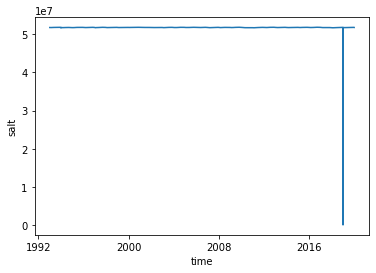

In [14]:
ds_wg.salt.sum(('st_ocean', 'yt_ocean', 'xt_ocean')).plot()

In [9]:
mask = ds_wg.time != ds_wg.time.sel(time='2018-12-24').values
salt_mask = ds_wg.salt.where(mask)#.load()
temp_mask = ds_wg.temp.where(mask)#.load()

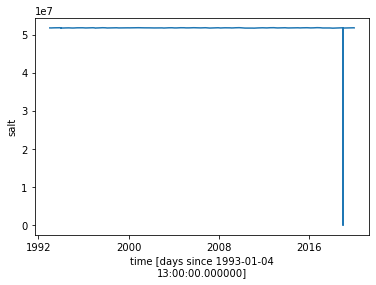

In [57]:
salt_mask.sum(('st_ocean', 'yt_ocean', 'xt_ocean')).plot()
#still shows dip bc of .sum() but mask does work!

In [20]:
salt_mask.dtype

dtype('float32')

In [10]:
#USE THIS!!
sigma2 = fastjmd95.rho(salt_mask, temp_mask, pref)

In [13]:
sigma2

<xarray.DataArray (time: 1970, st_ocean: 50, yt_ocean: 169, xt_ocean: 381)>
dask.array<transpose, shape=(1970, 50, 169, 381), dtype=float64, chunksize=(1, 50, 169, 381), chunktype=numpy.ndarray>
Coordinates:
  * st_ocean  (st_ocean) float64 5.034 15.1 25.22 ... 5.185e+03 5.395e+03
  * time      (time) object 1993-01-04 13:00:00 ... 2019-12-19 13:00:00
  * xt_ocean  (xt_ocean) float64 -65.12 -64.88 -64.62 ... 29.38 29.62 29.88
  * yt_ocean  (yt_ocean) float64 -80.02 -79.92 -79.81 ... -62.37 -62.25 -62.14

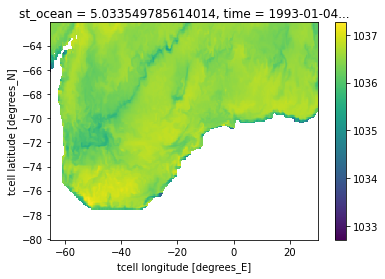

In [31]:
sigma2[0,0].plot()

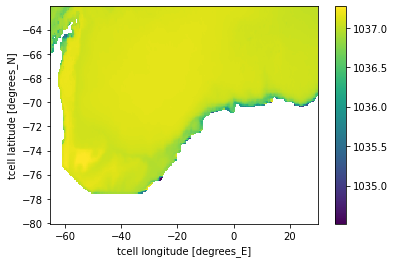

In [32]:
sigma2.mean(dim=['time', 'st_ocean']).plot()

In [25]:
sigma2.nbytes/1e9

50.738532

In [ ]:
sigma2.mean(dim=['time', 'st_ocean']).plot.hist()

### Volume-weighted $\frac{\partial{\sigma_2}}{\partial t} =$ _tottend_truth_

In [11]:
drhodt = fastjmd95.drhodt(salt_mask, temp_mask, pref)
drhods = fastjmd95.drhods(salt_mask, temp_mask, pref)

In [12]:
vol = cells.dx_interp * cells.dy_u * cells.dz

In [13]:
totttend_truth = (totend.totttend * drhodt[1:])# * vol)#.load()

In [14]:
totstend_truth = (totend.totstend * drhods[1:])# * vol)#.load()

In [19]:
delta_sigma = sigma2.isel(time=-1) - sigma2.isel(time=0)
total_time = (sigma2.time[-1] - sigma2.time[0]).astype('f8')*1e-9
totend_truth = (delta_sigma * vol) / total_time

In [16]:
dt_values = (surf.time.diff('time') / 1e9).astype('f4')
dt = xr.DataArray(dt_values, dims=['time'], 
                  coords={'time': (['time'], surf.time.values[1:])}) #shaves off first time stamp in `surf.time`
surf.coords['dt'] = dt

In [17]:
surf.dt[1:]

<xarray.DataArray 'dt' (time: 1969)>
array([432000., 432000., 432000., ..., 432000., 432000., 432000.],
      dtype=float32)
Coordinates:
  * time     (time) object 1993-01-09 13:00:00 ... 2019-12-19 13:00:00
    dt       (time) float32 4.32e+05 4.32e+05 4.32e+05 ... 4.32e+05 4.32e+05

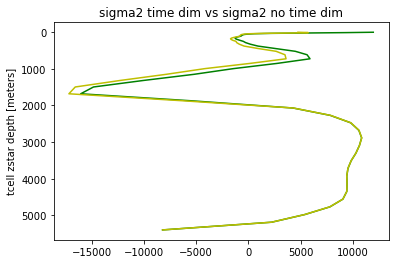

In [22]:
(sigma2.diff(dim='time')*vol/surf.dt[1:]).sum(dim=['yt_ocean', 'xt_ocean']).mean(dim='time').plot(y='st_ocean', yincrease=False, color='green')
totend_truth.sum(dim=['yt_ocean', 'xt_ocean']).plot(y='st_ocean', yincrease=False, color='y')
plt.title('sigma2 time dim vs sigma2 no time dim');

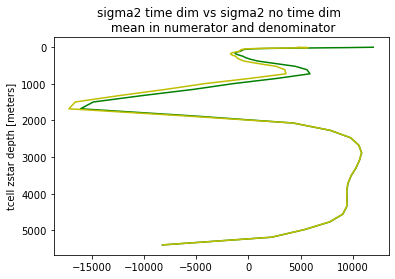

In [67]:
((sigma2.diff(dim='time')*vol).mean(dim='time')/surf.dt[1:].mean(dim='time')).sum(dim=['yt_ocean', 'xt_ocean']).plot(y='st_ocean', yincrease=False, 
                                                                                                               color='green')
totend_truth.sum(dim=['yt_ocean', 'xt_ocean']).plot(y='st_ocean', yincrease=False, color='y')
plt.title('sigma2 time dim vs sigma2 no time dim \n mean in numerator and denominator');

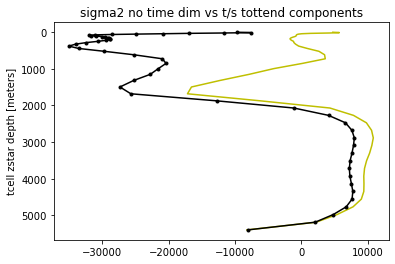

In [140]:
totend_truth.sum(dim=['yt_ocean', 'xt_ocean']).plot(y='st_ocean', yincrease=False, color='y')
(totttend_truth + totstend_truth).sum(dim=['yt_ocean', 'xt_ocean']).mean(dim='time').plot(y='st_ocean', yincrease=False, color='k', marker='.')
plt.title('sigma2 no time dim vs t/s tottend components');

In [ ]:
((sigma2.diff(dim='time')*vol).mean(dim='time')/surf.dt[1:].mean(dim='time')).sum(dim=['yt_ocean', 'xt_ocean']).plot(y='st_ocean', 
                                                                                                               yincrease=False, color='y')
(totttend_truth + totstend_truth).sum(dim=['yt_ocean', 'xt_ocean']).mean(dim='time').plot(y='st_ocean', yincrease=False, color='k', marker='.')
plt.title('sigma2 time dim vs t/s tottend components');

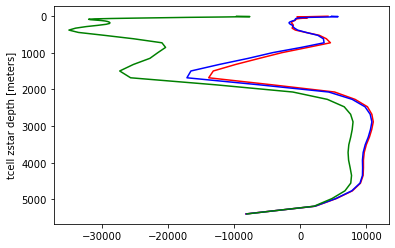

In [24]:
((sigma2.diff(dim='time')*vol).mean(dim='time')/surf.dt[1:].mean(dim='time')).sum(dim=['yt_ocean', 'xt_ocean']).plot(y='st_ocean', 
                                                                                                               yincrease=False, color='red')
totend_truth.sum(dim=['yt_ocean', 'xt_ocean']).plot(y='st_ocean', yincrease=False, color='blue')
(totttend_truth + totstend_truth).sum(dim=['yt_ocean', 'xt_ocean']).mean(dim='time').plot(y='st_ocean', yincrease=False, color='green');

In [18]:
totend_truth = ((sigma2.diff(dim='time') * vol) / surf.dt[1:]).drop('dt')#.load()

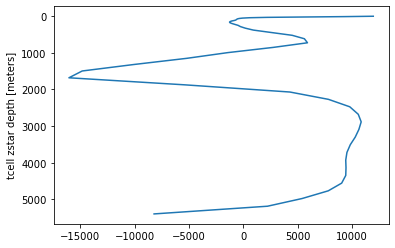

In [88]:
totend_truth.sum(['yt_ocean', 'xt_ocean']).mean(dim='time').plot(y='st_ocean', yincrease=False)

# <font color='Green'>\begin{equation*} \frac{\partial V}{\partial t} == \Omega_{tottend-\sigma-truth} + R1 \end{equation*} </font>

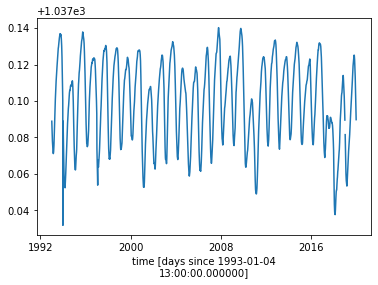

In [101]:
sigma2.mean(dim=['xt_ocean', 'yt_ocean', 'st_ocean']).plot()

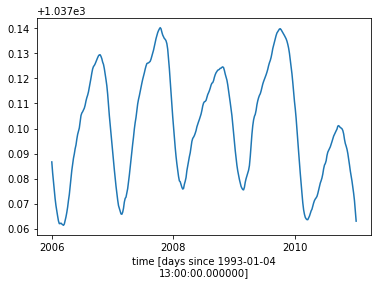

In [105]:
#SOSE time period
#density avged over volume gets denser in middle of the year (AA winter) and lighter around spring/summer
sigma2.sel(time=slice('2006', '2010')).mean(dim=['xt_ocean', 'yt_ocean', 'st_ocean']).plot()

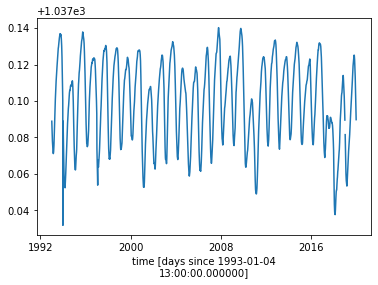

In [106]:
sigma2.sel(time=slice('1980', '2019')).mean(dim=['xt_ocean', 'yt_ocean', 'st_ocean']).plot()

In [107]:
sigma2.min().values

array(1032.01930673)

In [108]:
sigma2.max().values

array(1039.03267855)

In [20]:
# define bins (ECCO & SOSE bin size 1000)
delta_sigma = 0.01
sigma_bins = np.arange(1032.0, 1039.0, delta_sigma)

In [21]:
sigma_bins.size

700

In [21]:
client

Client Scheduler: gateway://traefik-gcp-uscentral1b-staging-dask-gateway.staging:80/staging.92d89cff39d94fc69f2831f34f8bcdd6 Dashboard: /services/dask-gateway/clusters/staging.92d89cff39d94fc69f2831f34f8bcdd6/status,Cluster Workers: 4 Cores: 8 Memory: 32.00 GiB


In [24]:
sigma_dist = histogram(sigma2.rename('sigma2'), bins=[sigma_bins],
                       weights=vol.fillna(0.), dim=['xt_ocean', 'yt_ocean', 'st_ocean']).load()

In [23]:
sigma_dist

<xarray.DataArray 'histogram_sigma2' (time: 1970, sigma2_bin: 699)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * time        (time) object 1993-01-04 13:00:00 ... 2019-12-19 13:00:00
  * sigma2_bin  (sigma2_bin) float64 1.032e+03 1.032e+03 ... 1.039e+03 1.039e+03

(1037.0, 1037.3)

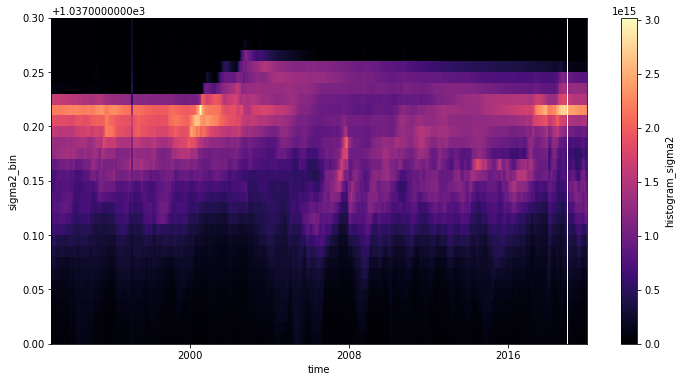

In [23]:
sigma_dist.where(mask).plot(x='time', figsize=(12, 6), cmap='magma')
plt.ylim(1037, 1037.3)

In [30]:
sigma_dist.sel(time=slice('1993-01-04', '2000-01-04'))

<xarray.DataArray 'histogram_sigma2' (time: 512, sigma2_bin: 699)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * time        (time) object 1993-01-04 13:00:00 ... 2000-01-03 13:00:00
  * sigma2_bin  (sigma2_bin) float64 1.032e+03 1.032e+03 ... 1.039e+03 1.039e+03

(1037.0, 1037.3)

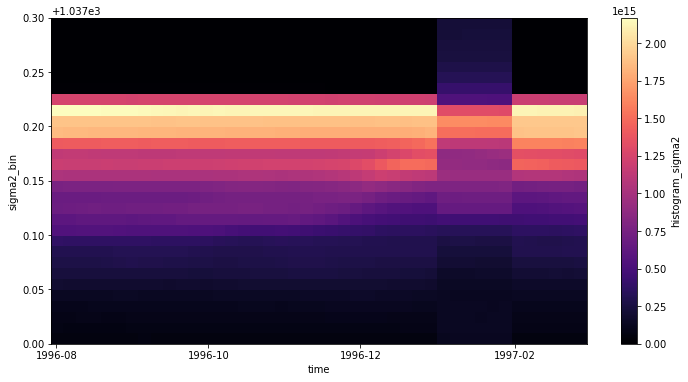

In [34]:
sigma_dist.sel(time=slice('1996-08', '1997-02')).where(mask).plot(x='time', figsize=(12, 6), cmap='magma')
plt.ylim(1037, 1037.3)

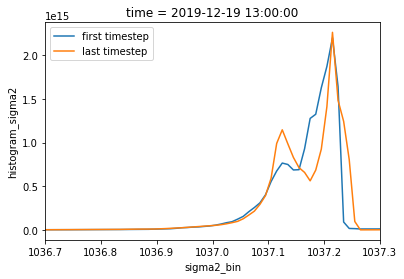

In [29]:
sigma_dist[0].plot(label='first timestep')
sigma_dist[-1].plot(label='last timestep')
plt.legend()
plt.xlim(1036.7, 1037.3);

(1037.5, 1036.4)

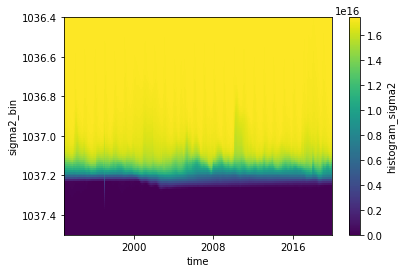

In [25]:
# cumulative volume
V = sigma_dist.isel(sigma2_bin=slice(None, None, -1)).cumsum(dim='sigma2_bin')
V.where(mask).transpose().plot()
plt.ylim(1037.5, 1036.4)

In [31]:
V

<xarray.DataArray 'histogram_sigma2' (time: 1970, sigma2_bin: 699)>
array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.74516139e+16, 1.74516139e+16, 1.74516139e+16],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.74516139e+16, 1.74516139e+16, 1.74516139e+16],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.74516139e+16, 1.74516139e+16, 1.74516139e+16],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.74516139e+16, 1.74516139e+16, 1.74516139e+16],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.74516139e+16, 1.74516139e+16, 1.74516139e+16],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.74516139e+16, 1.74516139e+16, 1.74516139e+16]])
Coordinates:
  * time        (time) object 1993-01-04 13:00:00 ... 2019-12-19 13:00:00
  * sigma2_bin  (sigma2_bin) float64 1.039e+03 1.039e+03 ... 1.032e+03 1.032e+03

(1037.5, 1037.0)

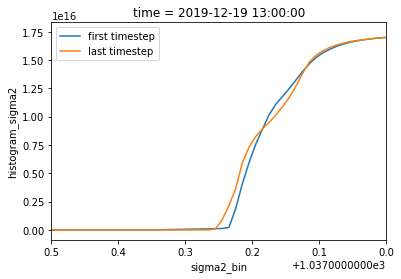

In [32]:
#waters with densities up to 1037.0 became lost volume and moved into denser sigma bins?
V[0].plot(label='first timestep')
V[-1].plot(label='last timestep')
plt.legend()
plt.xlim(1037.5, 1037)

In [26]:
delta_V = V.diff(dim='time')

In [26]:
delta_V

<xarray.DataArray 'histogram_sigma2' (time: 1969, sigma2_bin: 699)>
array([[  0.,   0.,   0., ...,   8.,   8.,   8.],
       [  0.,   0.,   0., ..., -18., -18., -18.],
       [  0.,   0.,   0., ...,  22.,  22.,  22.],
       ...,
       [  0.,   0.,   0., ...,  -8.,  -8.,  -8.],
       [  0.,   0.,   0., ...,  16.,  16.,  16.],
       [  0.,   0.,   0., ...,   4.,   4.,   4.]])
Coordinates:
  * time        (time) object 1993-01-09 13:00:00 ... 2019-12-19 13:00:00
  * sigma2_bin  (sigma2_bin) float64 1.039e+03 1.039e+03 ... 1.032e+03 1.032e+03

In [35]:
surf.dt[1:]

<xarray.DataArray 'dt' (time: 1969)>
array([432000., 432000., 432000., ..., 432000., 432000., 432000.],
      dtype=float32)
Coordinates:
  * time     (time) object 1993-01-09 13:00:00 ... 2019-12-19 13:00:00
    dt       (time) float32 4.32e+05 4.32e+05 4.32e+05 ... 4.32e+05 4.32e+05

## $\frac{\partial \mathcal{V}}{\partial t}$

In [27]:
dVdt = (delta_V / surf.dt[1:]).drop('dt')

In [28]:
dVdt

<xarray.DataArray (time: 1969, sigma2_bin: 699)>
array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         1.85185185e-05,  1.85185185e-05,  1.85185185e-05],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -4.16666667e-05, -4.16666667e-05, -4.16666667e-05],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         5.09259259e-05,  5.09259259e-05,  5.09259259e-05],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -1.85185185e-05, -1.85185185e-05, -1.85185185e-05],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         3.70370370e-05,  3.70370370e-05,  3.70370370e-05],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         9.25925926e-06,  9.25925926e-06,  9.25925926e-06]])
Coordinates:
  * time        (time) object 1993-01-09 13:00:00 ... 2019-12-19 13:00:00
  * sigma2_bin  (sigma2_bin) float64 1.039e+03 1.039e+03 ... 1.032e+03 1.032e+03

(1036.0, 1037.3)

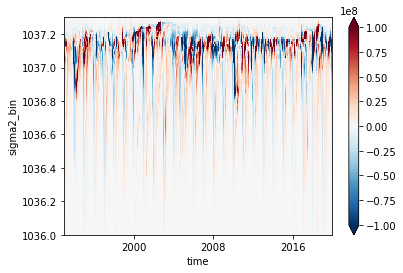

In [38]:
dVdt.where(mask).plot(x='time', vmax=1e8)
plt.ylim(1036, 1037.3)

(1036.0, 1037.3)

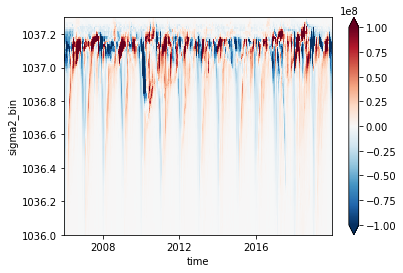

In [39]:
dVdt.where(mask).sel(time=slice('2006', '2019')).plot(x='time', vmax=1e8)
plt.ylim(1036, 1037.3)

## $\Omega_{total}$

In [40]:
omega_total = - histogram(sigma2[1:].rename('sigma2'), bins=[sigma_bins],
                          weights=totend_truth.fillna(0.),
                          dim=['yt_ocean', 'xt_ocean', 'st_ocean']) / (- delta_sigma)

In [ ]:
omega_total.load()

In [45]:
dVdt

<xarray.DataArray (time: 1969, sigma2_bin: 699)>
array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         1.85185185e-05,  1.85185185e-05,  1.85185185e-05],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -4.16666667e-05, -4.16666667e-05, -4.16666667e-05],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         5.09259259e-05,  5.09259259e-05,  5.09259259e-05],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -1.85185185e-05, -1.85185185e-05, -1.85185185e-05],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         3.70370370e-05,  3.70370370e-05,  3.70370370e-05],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         9.25925926e-06,  9.25925926e-06,  9.25925926e-06]])
Coordinates:
  * time        (time) object 1993-01-09 13:00:00 ... 2019-12-19 13:00:00
  * sigma2_bin  (sigma2_bin) float64 1.039e+03 1.039e+03 ... 1.032e+03 1.032e+03

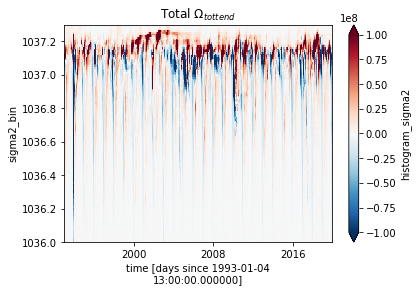

In [67]:
omega_total.plot(x='time', vmax=1e8)
plt.ylim(ymin=1036, ymax=1037.3)
plt.title(r'Total $\Omega_{tottend}$');

## <font color='Green'>\begin{equation*} R1 = \frac{\partial \mathcal{V}}{\partial t} - \Omega_{total} \end{equation*} (Discretization of sigma layers) </font>

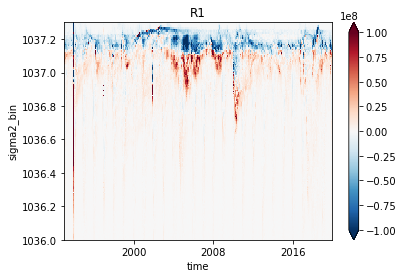

In [33]:
R1 = dVdt - omega_total

R1.where(mask).plot(x='time', vmax=1e8)
plt.ylim(ymin=1036, ymax=1037.3)
plt.title('R1');

In [76]:
dVdt

<xarray.DataArray (time: 1969, sigma2_bin: 699)>
array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         1.85185185e-05,  1.85185185e-05,  1.85185185e-05],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -4.16666667e-05, -4.16666667e-05, -4.16666667e-05],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         5.09259259e-05,  5.09259259e-05,  5.09259259e-05],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -1.85185185e-05, -1.85185185e-05, -1.85185185e-05],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         3.70370370e-05,  3.70370370e-05,  3.70370370e-05],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         9.25925926e-06,  9.25925926e-06,  9.25925926e-06]])
Coordinates:
  * time        (time) object 1993-01-09 13:00:00 ... 2019-12-19 13:00:00
  * sigma2_bin  (sigma2_bin) float64 1.039e+03 1.039e+03 ... 1.032e+03 1.032e+03

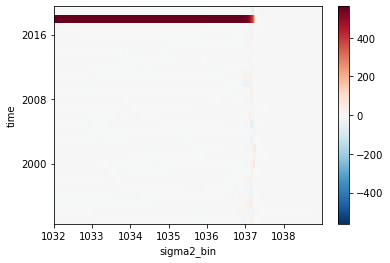

In [86]:
(dVdt/1e6).where(mask).resample(time='AS').mean(dim='time').plot()

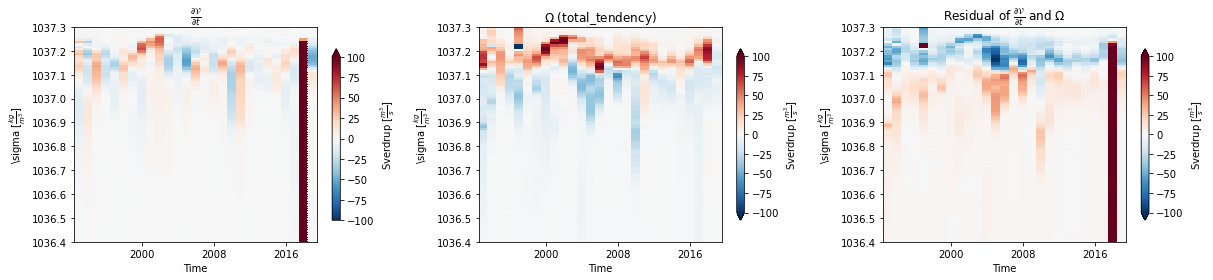

In [31]:
fig, (ax0,ax1,ax2) = plt.subplots(1, 3, figsize=(17, 4), sharex=True)

(dVdt/1e6).where(mask).resample(time='AS').mean(dim='time').plot(x='time', ax=ax0, vmax=100,
                                                     cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
ax0.set_ylabel(r'\sigma $[\frac{kg}{m^3}]$')#, fontsize=14)
ax0.set_xlabel('Time')#, fontsize=14)
ax0.set_title(r'$\frac{\partial \mathcal{V}}{\partial t}$')#, fontsize=24)
ax0.set_ylim(1036.4, 1037.3)

(omega_total/1e6).where(mask).resample(time='AS').mean(dim='time').plot(x='time', ax=ax1, vmax=100,
                                                            cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
ax1.set_ylabel(r'\sigma $[\frac{kg}{m^3}]$')
ax1.set_xlabel('Time')#, fontsize=14)
ax1.set_title('$\Omega$ (total_tendency)')
ax1.set_ylim(1036.4, 1037.3)

(R1/1e6).where(mask).resample(time='AS').mean(dim='time').plot(x='time', ax=ax2, vmax=100,
                                                   cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
ax2.set_ylabel(r'\sigma $[\frac{kg}{m^3}]$')
ax2.set_xlabel('Time')
ax2.set_title(r'Residual of $\frac{\partial \mathcal{V}}{\partial t}$ and $\Omega$')
ax2.set_ylim(1036.4, 1037.3)

plt.tight_layout();

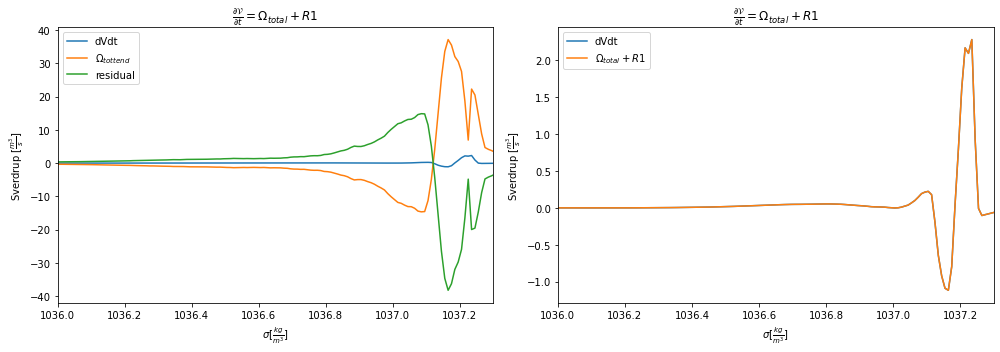

In [32]:
fig, (ax0,ax1) = plt.subplots(1, 2, figsize=(14, 5), sharex=True)

(dVdt/1e6).mean(dim='time').plot(label='dVdt', ax=ax0)
(omega_total/1e6).mean(dim='time').plot(label=r'$\Omega_{tottend}$', ax=ax0)
(R1/1e6).mean(dim='time').plot(label='residual', ax=ax0)
ax0.set_ylabel(r'Sverdrup [$\frac{m^3}{s}$]')
ax0.set_xlabel(r'$\sigma [\frac{kg}{m^3}]$')
ax0.legend()
ax0.set_title(r'$\frac{\partial \mathcal{V}}{\partial t} = \Omega_{total} + R1$')
ax0.set_xlim(1035.5, 1037.3)

(dVdt/1e6).mean(dim='time').plot(label='dVdt', ax=ax1)
((omega_total + R1)/1e6).mean(dim='time').plot(label=r'$\Omega_{total} + R1$', ax=ax1)
ax1.set_ylabel(r'Sverdrup [$\frac{m^3}{s}$]')
ax1.set_xlabel(r'$\sigma [\frac{kg}{m^3}]$')
ax1.legend()
ax1.set_title(r'$\frac{\partial \mathcal{V}}{\partial t} = \Omega_{total} + R1$')
ax1.set_xlim(1036, 1037.3)

plt.tight_layout();

## <span style='color:Green'> \begin{equation*} \Omega_{surf} \end{equation*}

In [42]:
surf

<xarray.Dataset>
Dimensions:             (st_ocean: 50, time: 1970, xt_ocean: 381, yt_ocean: 169)
Coordinates:
  * st_ocean            (st_ocean) float64 5.034 15.1 ... 5.185e+03 5.395e+03
  * time                (time) object 1993-01-04 13:00:00 ... 2019-12-19 13:0...
  * xt_ocean            (xt_ocean) float64 -65.12 -64.88 -64.62 ... 29.62 29.88
  * yt_ocean            (yt_ocean) float64 -80.02 -79.92 ... -62.25 -62.14
    dt                  (time) float32 nan 4.32e+05 ... 4.32e+05 4.32e+05
Data variables:
    surf_flux_conv_SLT  (time, st_ocean, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 50, 169, 381), meta=np.ndarray>
    surf_flux_conv_TH   (time, st_ocean, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 50, 169, 381), meta=np.ndarray>
    sw_flux_conv_TH     (time, yt_ocean, xt_ocean, st_ocean) float64 dask.array<chunksize=(1, 169, 381, 50), meta=np.ndarray>

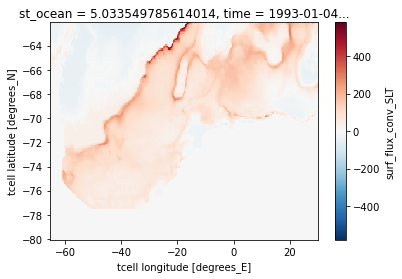

In [43]:
surf.surf_flux_conv_SLT[0,0].plot()

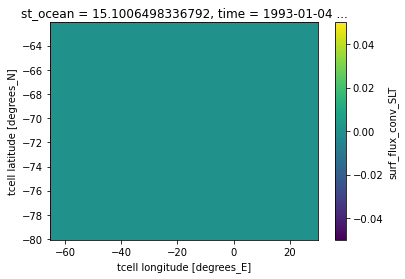

In [44]:
surf.surf_flux_conv_SLT[0,1].plot()

In [45]:
mask_surf = surf.surf_flux_conv_SLT != 0 

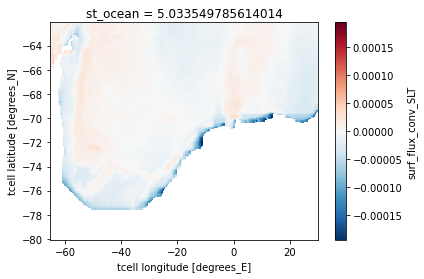

In [34]:
(surf.surf_flux_conv_SLT.where(mask_surf)/1e6).mean(dim='time')[0].plot()

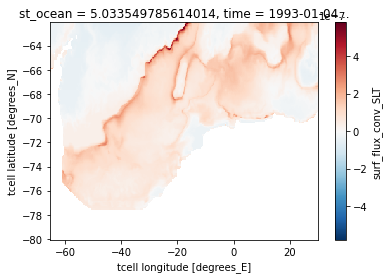

In [56]:
(surf.surf_flux_conv_SLT.where(mask_surf)/1e6)[0,0].plot()

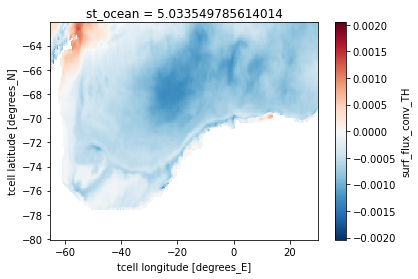

In [59]:
(surf.surf_flux_conv_TH.where(mask_surf)/1e6).mean(dim='time')[0].plot()

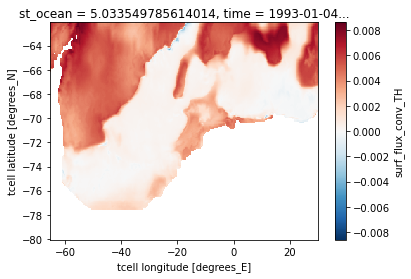

In [54]:
(surf.surf_flux_conv_TH.where(mask_surf)/1e6)[0,0].plot()

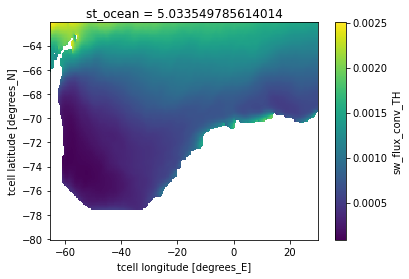

In [39]:
(surf.sw_flux_conv_TH.where(mask_surf)/1e6).mean(dim='time')[:,:,0].plot()

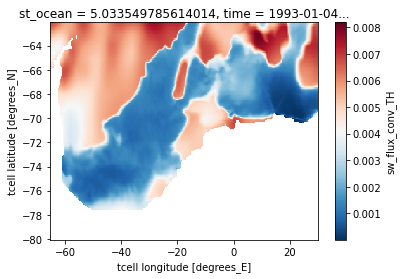

In [14]:
(surf.sw_flux_conv_TH/1e6).where(mask_surf)[0, :, :, 0].plot(cmap='RdBu_r')

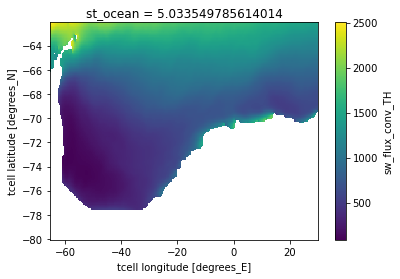

In [15]:
surf.sw_flux_conv_TH.where(mask_surf).mean(dim='time')[:,:,0].plot()

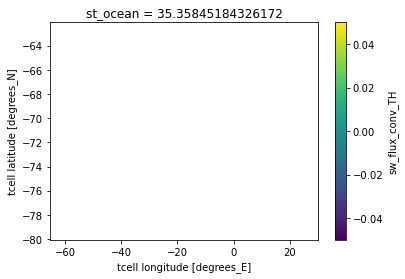

In [200]:
surf.sw_flux_conv_TH.where(mask_surf).mean(dim='time')[:,:,3].plot()

In [46]:
αsurf_TH = surf.surf_flux_conv_TH * drhodt
αsurf_sw = surf.sw_flux_conv_TH * drhodt
βsurf_SLT = surf.surf_flux_conv_SLT * drhods

In [43]:
βsurf_SLT

<xarray.DataArray (time: 1970, st_ocean: 50, yt_ocean: 169, xt_ocean: 381)>
dask.array<mul, shape=(1970, 50, 169, 381), dtype=float64, chunksize=(1, 50, 169, 381), chunktype=numpy.ndarray>
Coordinates:
  * st_ocean  (st_ocean) float64 5.034 15.1 25.22 ... 5.185e+03 5.395e+03
  * time      (time) object 1993-01-04 13:00:00 ... 2019-12-19 13:00:00
  * xt_ocean  (xt_ocean) float64 -65.12 -64.88 -64.62 ... 29.38 29.62 29.88
  * yt_ocean  (yt_ocean) float64 -80.02 -79.92 -79.81 ... -62.37 -62.25 -62.14
    dt        (time) float32 nan 4.32e+05 4.32e+05 ... 4.32e+05 4.32e+05

In [44]:
αsurf_sw[1:]

<xarray.DataArray (time: 1969, yt_ocean: 169, xt_ocean: 381, st_ocean: 50)>
dask.array<getitem, shape=(1969, 169, 381, 50), dtype=float64, chunksize=(1, 169, 381, 50), chunktype=numpy.ndarray>
Coordinates:
  * st_ocean  (st_ocean) float64 5.034 15.1 25.22 ... 5.185e+03 5.395e+03
  * time      (time) object 1993-01-09 13:00:00 ... 2019-12-19 13:00:00
  * xt_ocean  (xt_ocean) float64 -65.12 -64.88 -64.62 ... 29.38 29.62 29.88
  * yt_ocean  (yt_ocean) float64 -80.02 -79.92 -79.81 ... -62.37 -62.25 -62.14
    dt        (time) float32 4.32e+05 4.32e+05 4.32e+05 ... 4.32e+05 4.32e+05

In [45]:
sigma2

<xarray.DataArray (time: 1970, st_ocean: 50, yt_ocean: 169, xt_ocean: 381)>
dask.array<transpose, shape=(1970, 50, 169, 381), dtype=float64, chunksize=(1, 50, 169, 381), chunktype=numpy.ndarray>
Coordinates:
  * st_ocean  (st_ocean) float64 5.034 15.1 25.22 ... 5.185e+03 5.395e+03
  * time      (time) object 1993-01-04 13:00:00 ... 2019-12-19 13:00:00
  * xt_ocean  (xt_ocean) float64 -65.12 -64.88 -64.62 ... 29.38 29.62 29.88
  * yt_ocean  (yt_ocean) float64 -80.02 -79.92 -79.81 ... -62.37 -62.25 -62.14

In [46]:
omega_surf_TH = - (histogram(sigma2[1:].rename('sigma2'), bins=[sigma_bins],
                             weights=αsurf_TH[1:].drop('dt').fillna(0.), dim=['xt_ocean', 'yt_ocean', 'st_ocean']) / (-delta_sigma))
omega_surf_TH.load()

omega_sw_TH = - (histogram(sigma2[1:].rename('sigma2'), bins=[sigma_bins],
                           weights=αsurf_sw[1:].drop('dt').fillna(0.), dim=['xt_ocean', 'yt_ocean', 'st_ocean']) / (-delta_sigma))
omega_sw_TH.load()

omega_surf_SLT = - (histogram(sigma2[1:].rename('sigma2'), bins=[sigma_bins],
                              weights=βsurf_SLT[1:].drop('dt').fillna(0.), dim=['xt_ocean', 'yt_ocean', 'st_ocean']) / (-delta_sigma))
omega_surf_SLT.load()

omega_surf = omega_surf_TH + omega_sw_TH + omega_surf_SLT
omega_surf.load()

<xarray.DataArray 'histogram_sigma2' (time: 1969, sigma2_bin: 699)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * time        (time) object 1993-01-09 13:00:00 ... 2019-12-19 13:00:00
  * sigma2_bin  (sigma2_bin) float64 1.032e+03 1.032e+03 ... 1.039e+03 1.039e+03

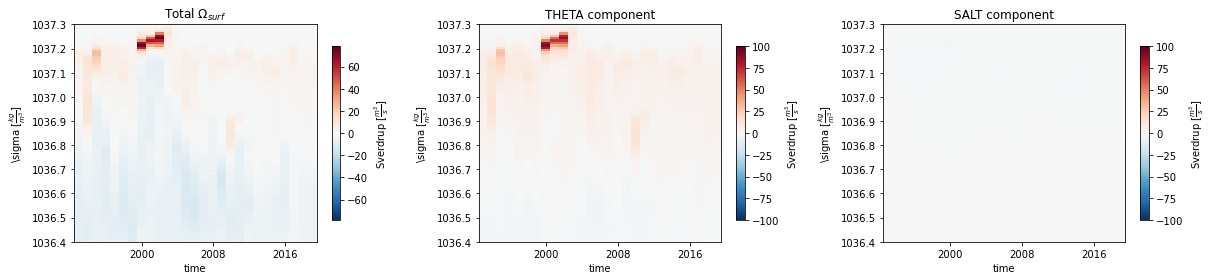

In [47]:
fig, (ax0,ax1,ax2) = plt.subplots(1,3, figsize=(17,4))

(omega_surf.resample(time='AS').mean()/1e6).plot(x='time', ax=ax0,
                                                       cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
ax0.set_ylim(1036.4, 1037.3)
ax0.set_ylabel(r'\sigma $[\frac{kg}{m^3}]$')
ax0.set_title(r'Total $\Omega_{surf}$')

(omega_surf_TH.resample(time='AS').mean()/1e6).plot(x='time', ax=ax1, vmax=100,
                                                          cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
ax1.set_ylim(1036.4, 1037.3)
ax1.set_ylabel(r'\sigma $[\frac{kg}{m^3}]$')
ax1.set_title('THETA component')

(omega_surf_SLT.resample(time='AS').mean()/1e6).plot(x='time', ax=ax2, vmax=100,
                                                           cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
ax2.set_ylim(1036.4, 1037.3)
ax2.set_ylabel(r'\sigma $[\frac{kg}{m^3}]$')
ax2.set_title('SALT component')

plt.tight_layout();

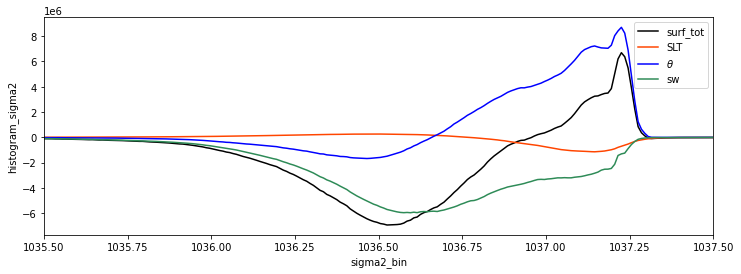

Exception in callback None()
handle: <Handle cancelled>
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.8/site-packages/tornado/iostream.py", line 1391, in _do_ssl_handshake
    self.socket.do_handshake()
  File "/srv/conda/envs/notebook/lib/python3.8/ssl.py", line 1309, in do_handshake
    self._sslobj.do_handshake()
ssl.SSLCertVerificationError: [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self signed certificate (_ssl.c:1125)

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/srv/conda/envs/notebook/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 189, in _handle_events
    handler_func(fileobj, events)
  File "/srv/conda/envs/notebook/lib/python3.8/site-packages/tornado/iostream.py", line 696, in _handle_events
    self._handle

In [52]:
plt.figure(figsize=(12,4))
omega_surf.mean(dim='time').plot(color='k', label='surf_tot')
omega_surf_SLT.mean(dim='time').plot(color='orangered', label='SLT')
omega_surf_TH.mean(dim='time').plot(color='blue', label=r'$\theta$')
omega_sw_TH.mean(dim='time').plot(color='seagreen', label='sw')
plt.xlim(1035.5, 1037.5)
plt.legend();

## <font color='Green'> \begin{equation*} NO\ \Psi_{adv} = \Psi_{vel} + R2 \end{equation*} </font>

## <font color='Green'>\begin{equation*} Transport/Vel\ terms \end{equation*}</font>

## <font color='Green'>\begin{equation*} \Psi_{vel} = \vec{\textbf{u}} \cdot \nabla \theta \end{equation*}</font>

In [28]:
grid_transport = xgcm.Grid(transport, coords={'X': {'center': 'xt_ocean', 'right': 'xu_ocean'}, 
                                              'Y': {'center': 'yt_ocean', 'right': 'yu_ocean'},
                                              'T': {'center': 'time'},
                                              'Z': {'center': 'st_edges_ocean', 'right': 'st_ocean'},
                                              'Zu': {'center': 'sw_edges_ocean', 'right': 'sw_ocean'}},
                     periodic=['X'])
grid_transport

<xgcm.Grid>
X Axis (periodic, boundary=None):
  * center   xt_ocean --> right
  * right    xu_ocean --> center
Y Axis (not periodic, boundary=None):
  * center   yt_ocean --> right
  * right    yu_ocean --> center
T Axis (not periodic, boundary=None):
  * center   time
Z Axis (not periodic, boundary=None):
  * center   st_edges_ocean --> right
  * right    st_ocean --> center
Zu Axis (not periodic, boundary=None):
  * center   sw_edges_ocean --> right
  * right    sw_ocean --> center

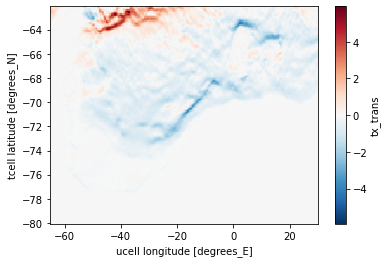

In [128]:
transport.tx_trans.sum(dim='st_ocean').mean(dim='time').plot()

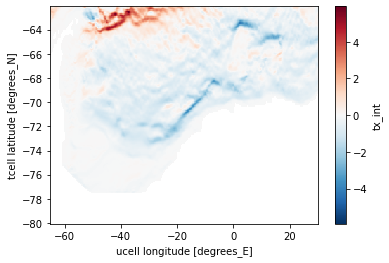

In [127]:
transport.tx_int.mean(dim='time').plot()

In [29]:
u_transport_right = (transport.tx_trans).isel(xu_ocean=-1)#.load()
u_transport_left = (transport.tx_trans).isel(xu_ocean=0)#.load()

v_transport = (transport.ty_trans).isel(yu_ocean=-1)#.load()

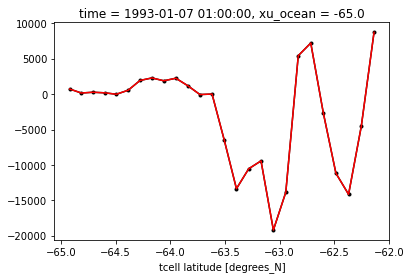

In [202]:
u_transport_left[0].sel(yt_ocean=slice(-65,-62)).plot(color='k', marker='.')
u_transport_left_int[0].sel(yt_ocean=slice(-65,-62)).plot(color='red')

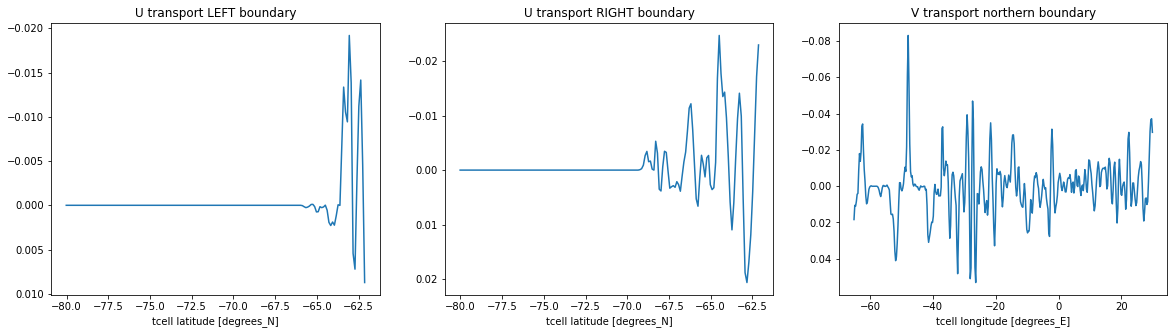

In [203]:
fig, (ax0,ax1,ax2) = plt.subplots(1,3, figsize=(20,5))

(u_transport_left[0]/1e6).plot(yincrease=False, ax=ax0)
ax0.set_title('U transport LEFT boundary')
(u_transport_right[0]/1e6).plot(yincrease=False, ax=ax1) 
ax1.set_title('U transport RIGHT boundary')
(v_transport[0]/1e6).plot(yincrease=False, ax=ax2)
ax2.set_title('V transport northern boundary');

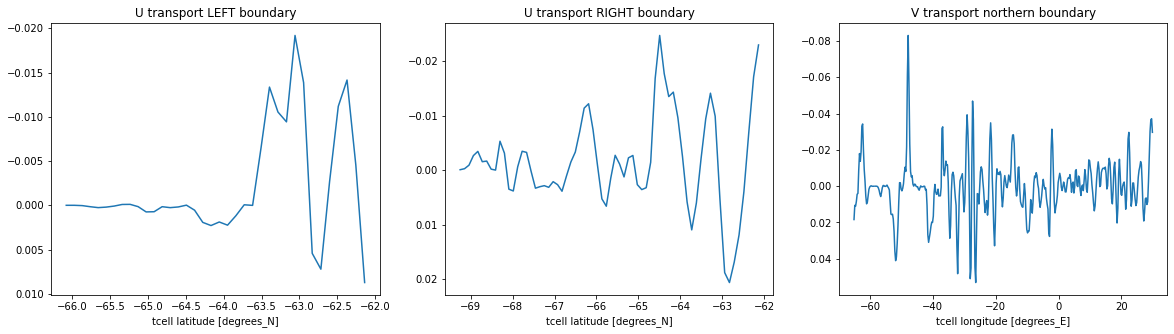

In [166]:
fig, (ax0,ax1,ax2) = plt.subplots(1,3, figsize=(20,5))

(u_transport_left_int[0]/1e6).plot(yincrease=False, ax=ax0)
ax0.set_title('U transport LEFT boundary')
(u_transport_right_int[0]/1e6).plot(yincrease=False, ax=ax1) 
ax1.set_title('U transport RIGHT boundary')
(v_transport_int[0]/1e6).plot(yincrease=False, ax=ax2)
ax2.set_title('V transport northern boundary');

In [113]:
# BEST WAY TO DO IT
u_transport_mean_value = (u_transport_right.fillna(0.).sum(dim=['yt_ocean', 'st_ocean']) -
                          u_transport_left.fillna(0.).sum(dim=['yt_ocean', 'st_ocean'])).mean(dim='time')
u_transport_mean_value.load()

<xarray.DataArray 'tx_trans' ()>
array(-38.79175, dtype=float32)

In [114]:
v_transport_mean_value = (v_transport).fillna(0.).sum(dim=['xt_ocean', 'st_ocean']).mean(dim='time')
v_transport_mean_value.load()

<xarray.DataArray 'ty_trans' ()>
array(38.92792, dtype=float32)
Coordinates:
    yu_ocean  float64 -62.08

In [115]:
residual = u_transport_mean_value + v_transport_mean_value #+ surf_transport_mean_value
float(residual)

0.13616943359375

In [40]:
#resample sigma2 to same timestep as transport, then interp transport terms timestamp to sigma2
#sigma2_resample = sigma2.resample(time='10D').mean()
#resample sigma2_resample to same time dim as transport time dim
sigma2_u_right_time_interp = sigma_at_u_right.interp(time=transport.time)
sigma2_u_left_time_interp = sigma_at_u_left.interp(time=transport.time)
sigma2_v_time_interp = sigma_at_v.interp(time=transport.time)

In [35]:
def interp_right_with_land(array, wet_mask):
    # there are several different ways to implement this; this is one
    
    data = wet_mask * np.nan_to_num(array)  # zeros the data on land
    data_shift = np.roll(data, 1, -1)
    
    wet_fac = wet_mask + np.roll(wet_mask, 1, -1)
    # wet_fac = 0: water on left AND right
    # wet_fac = 1: water on left OR right
    # wet_fac = 2: no land nearby
    
    # division by zero creates NaNs
    out =  1 / wet_fac * (data + data_shift)
    
    return np.nan_to_num(out)

In [82]:
wet_mask_full = sigma2.notnull().astype(np.int8)
wet_mask_full

<xarray.DataArray (time: 1970, st_ocean: 50, yt_ocean: 169, xt_ocean: 381)>
dask.array<astype, shape=(1970, 50, 169, 381), dtype=int8, chunksize=(1, 50, 169, 381), chunktype=numpy.ndarray>
Coordinates:
  * st_ocean  (st_ocean) float64 5.034 15.1 25.22 ... 5.185e+03 5.395e+03
  * time      (time) object 1993-01-04 13:00:00 ... 2019-12-19 13:00:00
  * xt_ocean  (xt_ocean) float64 -65.12 -64.88 -64.62 ... 29.38 29.62 29.88
  * yt_ocean  (yt_ocean) float64 -80.02 -79.92 -79.81 ... -62.37 -62.25 -62.14

In [85]:
sigma_at_tx_full = xr.apply_ufunc(
    interp_right_with_land,
    sigma2,
    wet_mask_full,
    dask='parallelized',
    input_core_dims=[['yt_ocean', 'xt_ocean'], ['yt_ocean', 'xt_ocean']],
    output_core_dims=[['yt_ocean', 'xu_ocean']],
    dask_gufunc_kwargs=dict(output_sizes={'xu_ocean': transport.dims['xu_ocean']}),
    output_dtypes=[sigma2.dtype],
).assign_coords(xu_ocean=transport.xu_ocean)

sigma_at_ty_full = xr.apply_ufunc(
    interp_right_with_land,
    sigma2,
    wet_mask_full,
    dask='parallelized',
    input_core_dims=[['yt_ocean', 'xt_ocean'], ['yt_ocean', 'xt_ocean']],
    output_core_dims=[['yu_ocean', 'xt_ocean']],
    dask_gufunc_kwargs=dict(output_sizes={'yu_ocean': transport.dims['yu_ocean']}),
    output_dtypes=[sigma2.dtype],
).assign_coords(yu_ocean=transport.yu_ocean)


In [77]:
sigma_at_tx_full.equals(sigma_at_tx_full.where(sigma_at_tx_full.notnull()))

True

In [92]:
sigma_at_ty_full.equals(sigma_at_ty_full.where(sigma_at_ty_full.notnull()))

True

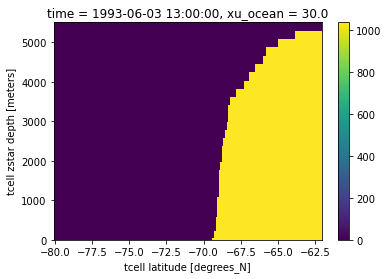

In [84]:
sigma_at_tx_full.isel(xu_ocean=-1)[30].plot()

In [101]:
#interp sigma time dim onto transport time dim
sigma2_u_right_time_interp = sigma_at_tx_full.isel(xu_ocean=-1).interp(time=transport.time)
sigma2_u_left_time_interp = sigma_at_tx_full.isel(xu_ocean=0).interp(time=transport.time)
sigma2_v_time_interp = sigma_at_ty_full.isel(yu_ocean=-1).interp(time=transport.time)

In [218]:
u = (u_right_time_interp.fillna(0.).sum(dim='yt_ocean') -
                          u_left_time_interp.fillna(0.).sum(dim='yt_ocean')).mean(dim='time')/1e6
u.load()

<xarray.DataArray ()>
array(-0.46981381)

In [219]:
v = (v_time_interp).fillna(0.).sum(dim='xt_ocean').mean(dim='time')/1e6
v.load()

<xarray.DataArray ()>
array(0.50653979)
Coordinates:
    yu_ocean  float64 -62.08

In [220]:
r = u + v
float(r)

0.03672597978611558

In [59]:
u_right_time_interp

<xarray.DataArray 'tx_trans' (time: 985, yt_ocean: 169)>
dask.array<transpose, shape=(985, 169), dtype=float32, chunksize=(985, 169), chunktype=numpy.ndarray>
Coordinates:
    xu_ocean  float64 30.0
  * yt_ocean  (yt_ocean) float64 -80.02 -79.92 -79.81 ... -62.37 -62.25 -62.14
  * time      (time) object 1993-01-04 00:00:00 ... 2019-12-14 00:00:00

In [78]:
u_transport_right.sum(dim=('yt_ocean', 'st_ocean'))[0]

<xarray.DataArray 'tx_trans' ()>
array(-9.028181, dtype=float32)
Coordinates:
    time      object 1993-01-07 01:00:00
    xu_ocean  float64 30.0

In [108]:
#this is the delta function part of the equation above
u_binned_right = histogram(sigma2_u_right_time_interp.rename('sigma2'), bins=[sigma_bins],
                           weights=u_transport_right.fillna(0.), dim=['st_ocean','yt_ocean']).load()
u_binned_left = histogram(sigma2_u_left_time_interp.rename('sigma2'), bins=[sigma_bins],
                          weights=u_transport_left.fillna(0.), dim=['st_ocean','yt_ocean']).load()
v_binned = histogram(sigma2_v_time_interp.rename('sigma2'), bins=[sigma_bins],
                     weights=v_transport.fillna(0.), dim=['st_ocean','xt_ocean']).load()

In [107]:
u_binned_right.sum(dim=('sigma2_bin'))[0].compute()

<xarray.DataArray 'histogram_sigma2' ()>
array(-9.02818043)
Coordinates:
    time     object 1993-01-07 01:00:00

In [122]:
u_transport_right.coords

Coordinates:
  * st_ocean  (st_ocean) float64 5.034 15.1 25.22 ... 5.185e+03 5.395e+03
  * time      (time) object 1993-01-07 01:00:00 ... 2019-12-17 01:00:00
    xu_ocean  float64 30.0
  * yt_ocean  (yt_ocean) float64 -80.02 -79.92 -79.81 ... -62.37 -62.25 -62.14

In [126]:
u_transport_left.coords

Coordinates:
  * st_ocean  (st_ocean) float64 5.034 15.1 25.22 ... 5.185e+03 5.395e+03
  * time      (time) object 1993-01-07 01:00:00 ... 2019-12-17 01:00:00
    xu_ocean  float64 -65.0
  * yt_ocean  (yt_ocean) float64 -80.02 -79.92 -79.81 ... -62.37 -62.25 -62.14

In [128]:
v_transport.coords

Coordinates:
  * st_ocean  (st_ocean) float64 5.034 15.1 25.22 ... 5.185e+03 5.395e+03
  * time      (time) object 1993-01-07 01:00:00 ... 2019-12-17 01:00:00
  * xt_ocean  (xt_ocean) float64 -65.12 -64.88 -64.62 ... 29.38 29.62 29.88
    yu_ocean  float64 -62.08

In [125]:
sigma2_u_right_time_interp.coords

Coordinates:
  * st_ocean  (st_ocean) float64 5.034 15.1 25.22 ... 5.185e+03 5.395e+03
  * yt_ocean  (yt_ocean) float64 -80.02 -79.92 -79.81 ... -62.37 -62.25 -62.14
    xu_ocean  float64 30.0
  * time      (time) object 1993-01-07 01:00:00 ... 2019-12-17 01:00:00

In [109]:
float((-u_binned_left + u_binned_right + v_binned).sum('sigma2_bin').mean(dim='time'))

0.13837522833578175

In [116]:
#`isel` is letting cumsum act in reverse order (from densenst to lightest)
psi_vel = - (u_binned_right 
             - u_binned_left 
             + v_binned).isel(sigma2_bin=slice(None, None, -1)).cumsum(dim='sigma2_bin')
psi_vel.load()

<xarray.DataArray 'histogram_sigma2' (time: 985, sigma2_bin: 699)>
array([[-0.        , -0.        , -0.        , ..., -1.3514323 ,
        -1.3514323 , -1.3514323 ],
       [-0.        , -0.        , -0.        , ..., -0.41340604,
        -0.41340604, -0.41340604],
       [-0.        , -0.        , -0.        , ..., -1.26238197,
        -1.26238197, -1.26238197],
       ...,
       [-0.        , -0.        , -0.        , ...,  0.25241277,
         0.25241277,  0.25241277],
       [-0.        , -0.        , -0.        , ...,  0.11213115,
         0.11213115,  0.11213115],
       [-0.        , -0.        , -0.        , ..., -0.38434065,
        -0.38434065, -0.38434065]])
Coordinates:
  * time        (time) object 1993-01-07 01:00:00 ... 2019-12-17 01:00:00
  * sigma2_bin  (sigma2_bin) float64 1.039e+03 1.039e+03 ... 1.032e+03 1.032e+03

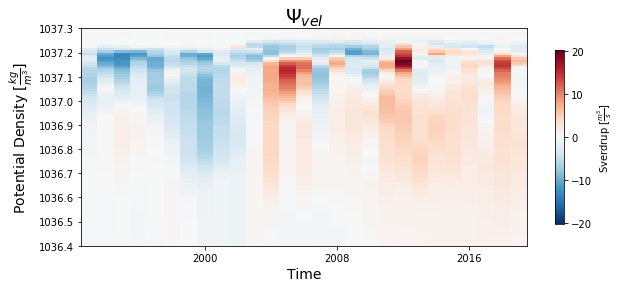

In [120]:
psi_vel.resample(time='AS').mean(dim='time').plot(x='time', figsize=(10,4),
                                                        cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
plt.ylabel(r'Potential Density $[\frac{kg}{m^3}]$', fontsize=14)
plt.xlabel('Time', fontsize=14)
plt.title('$\Psi_{vel}$', fontsize=20)
plt.ylim(1036.4, 1037.3);

(1036.5, 1037.5)

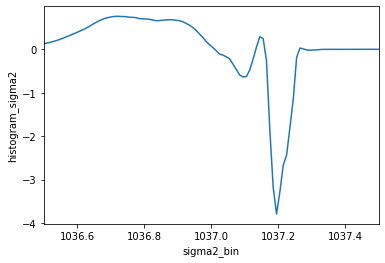

In [121]:
psi_vel.mean(dim='time').plot()
plt.xlim(1036.5, 1037.5)

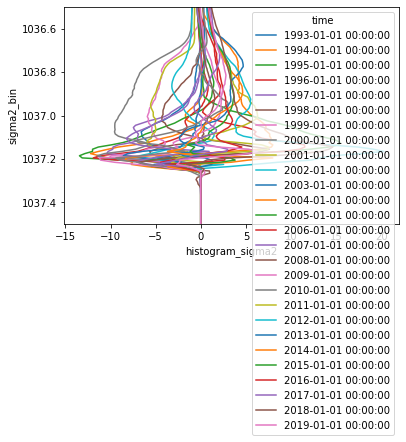

In [135]:
psi_vel.resample(time='AS').mean(dim='time').plot.line(y='sigma2_bin');#, add_legend=True)
plt.ylim(1037.5, 1036.5);

## NO R2 = $\Psi_{adv} - \Psi_{vel}$ (Numerical Mixing)

# <font color='Green'>\begin{equation*} \Omega_{tottend-truth} = \Psi_{vel} + \Omega_{surf} + R2 \end{equation*} </font>

In [120]:
omegas = xr.merge([omega_total.rename('omega_total'), omega_surf.rename('omega_surf'),
                           omega_surf_SLT.rename('omega_surf_SLT'), omega_surf_TH.rename('omega_surf_TH'),
                           omega_sw_TH.rename('omega_sw_TH')])

In [125]:
omega_resample = omegas.resample(time='10D').mean().interp(time=psi_vel.time)

In [127]:
omega_resample.time

<xarray.DataArray 'time' (time: 985)>
array([cftime.DatetimeJulian(1993, 1, 4, 0, 0, 0, 0),
       cftime.DatetimeJulian(1993, 1, 14, 0, 0, 0, 0),
       cftime.DatetimeJulian(1993, 1, 24, 0, 0, 0, 0), ...,
       cftime.DatetimeJulian(2019, 11, 24, 0, 0, 0, 0),
       cftime.DatetimeJulian(2019, 12, 4, 0, 0, 0, 0),
       cftime.DatetimeJulian(2019, 12, 14, 0, 0, 0, 0)], dtype=object)
Coordinates:
  * time     (time) object 1993-01-04 00:00:00 ... 2019-12-14 00:00:00

In [124]:
psi_vel.time

<xarray.DataArray 'time' (time: 985)>
array([cftime.DatetimeJulian(1993, 1, 4, 0, 0, 0, 0),
       cftime.DatetimeJulian(1993, 1, 14, 0, 0, 0, 0),
       cftime.DatetimeJulian(1993, 1, 24, 0, 0, 0, 0), ...,
       cftime.DatetimeJulian(2019, 11, 24, 0, 0, 0, 0),
       cftime.DatetimeJulian(2019, 12, 4, 0, 0, 0, 0),
       cftime.DatetimeJulian(2019, 12, 14, 0, 0, 0, 0)], dtype=object)
Coordinates:
  * time     (time) object 1993-01-04 00:00:00 ... 2019-12-14 00:00:00

In [131]:
omega_total.coords

Coordinates:
  * time        (time) object 1993-01-09 13:00:00 ... 2019-12-19 13:00:00
  * sigma2_bin  (sigma2_bin) float64 1.032e+03 1.032e+03 ... 1.039e+03 1.039e+03

In [135]:
R2 = omega_resample.omega_total - psi_vel - omega_resample.omega_surf
R2_th = omega_resample.omega_total - psi_vel - omega_resample.omega_surf_TH
R2_slt = omega_resample.omega_total - psi_vel - omega_resample.omega_surf_SLT
R2_sw = omega_resample.omega_total - psi_vel - omega_resample.omega_sw_TH

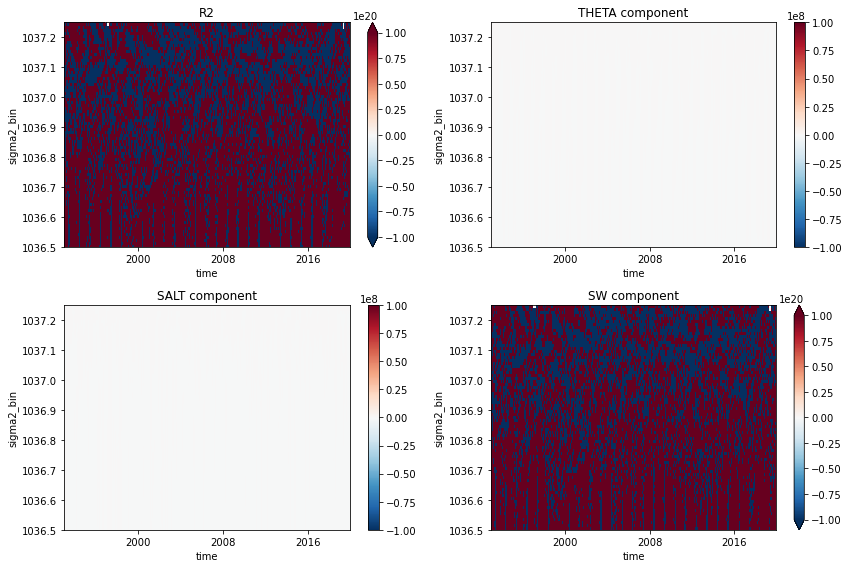

In [144]:
fig, axes = plt.subplots(2, 2, figsize=(12,8))

(R2/1e6).plot(x='time', ax=axes[0,0], vmax=1e20)
axes[0,0].set_ylim(ymax=1037.25, ymin=1036.5)
axes[0,0].set_title('R2')

(R2_th/1e6).plot(x='time', vmax=1e8, ax=axes[0,1])
axes[0,1].set_ylim(ymax=1037.25, ymin=1036.5)
axes[0,1].set_title('THETA component')

(R2_slt/1e6).plot(x='time', vmax=1e8, ax=axes[1,0])
axes[1,0].set_ylim(ymax=1037.25, ymin=1036.5)
axes[1,0].set_title('SALT component')

(R2_sw/1e6).plot(x='time', vmax=1e20, ax=axes[1,1])
axes[1,1].set_ylim(ymax=1037.25, ymin=1036.5)
axes[1,1].set_title('SW component')

plt.tight_layout();

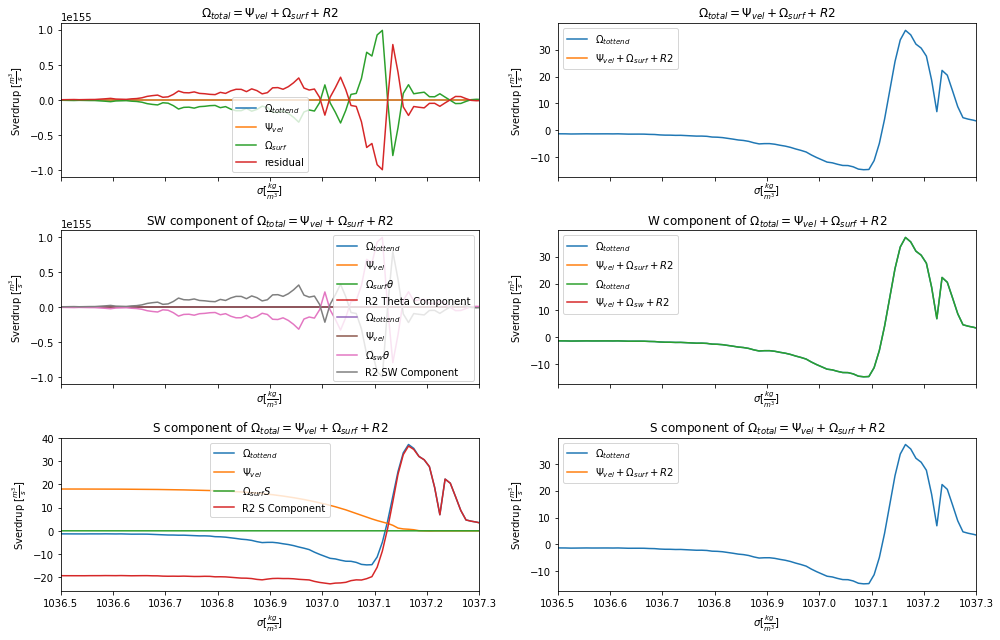

In [146]:
fig, axes = plt.subplots(3, 2, figsize=(14, 9), sharex=True)

(omega_total/1e6).mean(dim='time').plot(label=r'$\Omega_{tottend}$', ax=axes[0,0])
(psi_vel/1e6).mean(dim='time').plot(label=r'$\Psi_{vel}$', ax=axes[0,0])
(omega_surf/1e6).mean(dim='time').plot(label=r'$\Omega_{surf}$', ax=axes[0,0])
(R2/1e6).mean(dim='time').plot(label='residual', ax=axes[0,0])
axes[0,0].set_ylabel(r'Sverdrup [$\frac{m^3}{s}$]')
axes[0,0].set_xlabel(r'$\sigma [\frac{kg}{m^3}]$')
axes[0,0].legend()
axes[0,0].set_title(r'$\Omega_{total} = \Psi_{vel} + \Omega_{surf} + R2$')
axes[0,0].set_xlim(1036.5, 1037.3)

(omega_total/1e6).mean(dim='time').plot(label=r'$\Omega_{tottend}$', ax=axes[0,1])
((psi_vel + omega_surf + R2)/1e6).mean(dim='time').plot(label=r'$\Psi_{vel} + \Omega_{surf} + R2$', ax=axes[0,1])
axes[0,1].set_ylabel(r'Sverdrup [$\frac{m^3}{s}$]')
axes[0,1].set_xlabel(r'$\sigma [\frac{kg}{m^3}]$')
axes[0,1].legend()
axes[0,1].set_title(r'$\Omega_{total} = \Psi_{vel} + \Omega_{surf} + R2$')
axes[0,1].set_xlim(1036.5, 1037.3)

(omega_total/1e6).mean(dim='time').plot(label=r'$\Omega_{tottend}$', ax=axes[1,0])
(psi_vel/1e6).mean(dim='time').plot(label=r'$\Psi_{vel}$', ax=axes[1,0])
(omega_surf_TH/1e6).mean(dim='time').plot(label=r'$\Omega_{surf} \theta$', ax=axes[1,0])
(R2_th/1e6).mean(dim='time').plot(label='R2 Theta Component', ax=axes[1,0])
axes[1,0].set_ylabel(r'Sverdrup [$\frac{m^3}{s}$]')
axes[1,0].set_xlabel(r'$\sigma [\frac{kg}{m^3}]$')
axes[1,0].legend()
axes[1,0].set_title(r'$\theta$ component of $\Omega_{total} = \Psi_{vel} + \Omega_{surf} + R2$')
axes[1,0].set_xlim(1036.5, 1037.3)

(omega_total/1e6).mean(dim='time').plot(label=r'$\Omega_{tottend}$', ax=axes[1,1])
((psi_vel + omega_surf_TH + R2_th)/1e6).mean(dim='time').plot(label=r'$\Psi_{vel} + \Omega_{surf} + R2$', ax=axes[1,1])
axes[1,1].set_ylabel(r'Sverdrup [$\frac{m^3}{s}$]')
axes[1,1].set_xlabel(r'$\sigma [\frac{kg}{m^3}]$')
axes[1,1].legend()
axes[1,1].set_title(r'$\theta$ component of $\Omega_{total} = \Psi_{vel} + \Omega_{surf} + R2$')
axes[1,1].set_xlim(1036.5, 1037.3)

(omega_total/1e6).mean(dim='time').plot(label=r'$\Omega_{tottend}$', ax=axes[2,0])
(psi_vel/1e6).mean(dim='time').plot(label=r'$\Psi_{vel}$', ax=axes[2,0])
(omega_surf_SLT/1e6).mean(dim='time').plot(label=r'$\Omega_{surf} S$', ax=axes[2,0])
(R2_slt/1e6).mean(dim='time').plot(label='R2 S Component', ax=axes[2,0])
axes[2,0].set_ylabel(r'Sverdrup [$\frac{m^3}{s}$]')
axes[2,0].set_xlabel(r'$\sigma [\frac{kg}{m^3}]$')
axes[2,0].legend()
axes[2,0].set_title(r'S component of $\Omega_{total} = \Psi_{vel} + \Omega_{surf} + R2$')
axes[2,0].set_xlim(1036.5, 1037.3)

(omega_total/1e6).mean(dim='time').plot(label=r'$\Omega_{tottend}$', ax=axes[2,1])
((psi_vel + omega_surf_SLT + R2_slt)/1e6).mean(dim='time').plot(label=r'$\Psi_{vel} + \Omega_{surf} + R2$', ax=axes[2,1])
axes[2,1].set_ylabel(r'Sverdrup [$\frac{m^3}{s}$]')
axes[2,1].set_xlabel(r'$\sigma [\frac{kg}{m^3}]$')
axes[2,1].legend()
axes[2,1].set_title(r'S component of $\Omega_{total} = \Psi_{vel} + \Omega_{surf} + R2$')
axes[2,1].set_xlim(1036.5, 1037.3)

(omega_total/1e6).mean(dim='time').plot(label=r'$\Omega_{tottend}$', ax=axes[1,0])
(psi_vel/1e6).mean(dim='time').plot(label=r'$\Psi_{vel}$', ax=axes[1,0])
(omega_sw_TH/1e6).mean(dim='time').plot(label=r'$\Omega_{sw} \theta$', ax=axes[1,0])
(R2_sw/1e6).mean(dim='time').plot(label='R2 SW Component', ax=axes[1,0])
axes[1,0].set_ylabel(r'Sverdrup [$\frac{m^3}{s}$]')
axes[1,0].set_xlabel(r'$\sigma [\frac{kg}{m^3}]$')
axes[1,0].legend()
axes[1,0].set_title(r'SW component of $\Omega_{total} = \Psi_{vel} + \Omega_{surf} + R2$')
axes[1,0].set_xlim(1036.5, 1037.3)

(omega_total/1e6).mean(dim='time').plot(label=r'$\Omega_{tottend}$', ax=axes[1,1])
((psi_vel + omega_surf_TH + R2_th)/1e6).mean(dim='time').plot(label=r'$\Psi_{vel} + \Omega_{sw} + R2$', ax=axes[1,1])
axes[1,1].set_ylabel(r'Sverdrup [$\frac{m^3}{s}$]')
axes[1,1].set_xlabel(r'$\sigma [\frac{kg}{m^3}]$')
axes[1,1].legend()
axes[1,1].set_title(r'W component of $\Omega_{total} = \Psi_{vel} + \Omega_{surf} + R2$')
axes[1,1].set_xlim(1036.5, 1037.3)

plt.tight_layout();

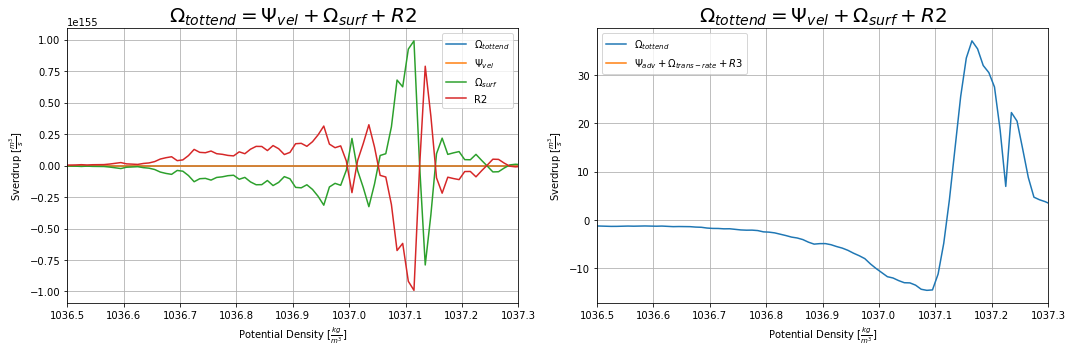

In [149]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(15, 5), sharex=True)

(omega_total/1e6).mean(dim='time').plot(label=r'$\Omega_{tottend}$', ax=ax0)
(psi_vel/1e6).mean(dim='time').plot(label=r'$\Psi_{vel}$', ax=ax0)
(omega_surf/1e6).mean(dim='time').plot(label=r'$\Omega_{surf}$', ax=ax0)
(R2/1e6).mean(dim='time').plot(label='R2', ax=ax0)
ax0.set_ylabel(r'Sverdrup [$\frac{m^3}{s}$]')
ax0.set_xlabel(r'Potential Density $[\frac{kg}{m^3}]$')
ax0.legend()
ax0.grid()
ax0.set_title(r'$\Omega_{tottend} = \Psi_{vel} + \Omega_{surf} + R2$', fontsize=20)
ax0.set_xlim(1036.5, 1037.3)

(omega_total/1e6).mean(dim='time').plot(label=r'$\Omega_{tottend}$', ax=ax1)
((psi_vel + omega_surf + R2)/1e6).mean(dim='time').plot(label=r'$\Psi_{adv}+\Omega_{trans-rate}+R3$', ax=ax1)
ax1.set_ylabel(r'Sverdrup [$\frac{m^3}{s}$]')
ax1.set_xlabel(r'Potential Density $[\frac{kg}{m^3}]$')
ax1.legend()
ax1.grid()
ax1.set_title(r'$\Omega_{tottend} = \Psi_{vel} + \Omega_{surf} + R2$', fontsize=20)
ax1.set_xlim(1036.5, 1037.3)

plt.tight_layout();

(1037.5, 1036.5)

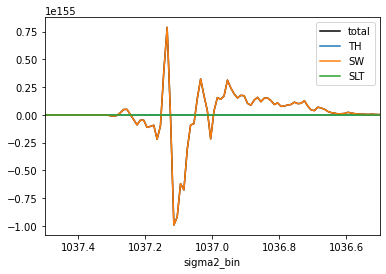

In [150]:
(R2/1e6).mean(dim='time').plot(color='k', label='total')
(R2_th/1e6).mean(dim='time').plot(label='TH')
(R2_sw/1e6).mean(dim='time').plot(label='SW')
(R2_slt/1e6).mean(dim='time').plot(label='SLT')
plt.legend()
plt.xlim(1037.5, 1036.5)

# <font color='Green'>\begin{equation*} \frac{\partial{V}}{\partial{t}} = \Psi_{vel} + \Omega_{surf} + R2 + R1\end{equation*} </font>

> `R1` discretization residual

> `R2` residual due to diffusion, numerical mixing, cabbeling, thermobaricity

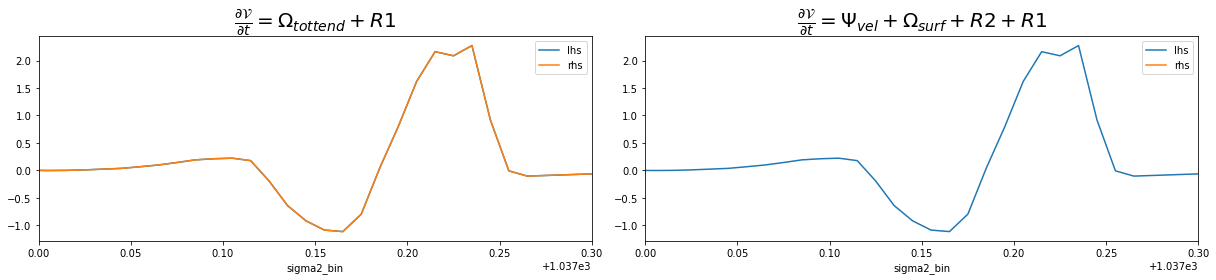

In [153]:
fig, (ax0,ax1) = plt.subplots(1, 2, figsize=(17,4))

(dVdt/1e6).mean(dim='time').plot(label='lhs', ax=ax0) 
((omega_total + R1)/1e6).mean(dim='time').plot(label='rhs', ax=ax0)
ax0.set_title(r'$\frac{\partial \mathcal{V}}{\partial t} = \Omega_{tottend} + R1$', fontsize=20, fontweight='bold')
ax0.legend()
ax0.set_xlim(1037, 1037.3)

(dVdt/1e6).mean(dim='time').plot(label='lhs', ax=ax1) 
((psi_vel + omega_surf + R2 + R1)/1e6).mean(dim='time').plot(label='rhs', ax=ax1)
ax1.set_title(r'$\frac{\partial \mathcal{V}}{\partial t} = \Psi_{vel} + \Omega_{surf} + R2 + R1$', fontsize=20, fontweight='bold')
ax1.legend()
ax1.set_xlim(1037, 1037.3)

plt.tight_layout();

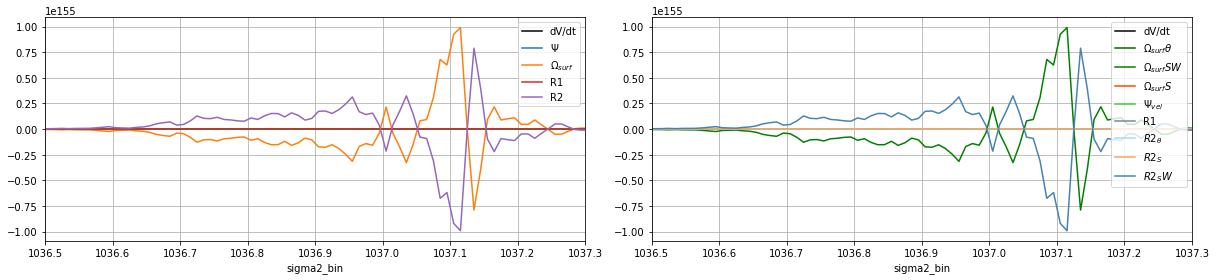

In [155]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(17, 4), sharex=True)

(dVdt/1e6).mean(dim='time').plot(label='dV/dt', color='k', ax=ax0)
(psi_vel/1e6).mean(dim='time').plot(label=r'$\Psi$', ax=ax0)
(omega_surf/1e6).mean(dim='time').plot(label=r'$\Omega_{surf}$', ax=ax0)
(psi_vel[1:-1]/1e6).mean(dim='time').plot(label=r'', ax=ax0)

(R1/1e6).mean(dim='time').plot(label='R1', ax=ax0)
(R2/1e6).mean(dim='time').plot(label='R2', ax=ax0)
ax0.legend()
ax0.grid()
ax0.set_xlim(1036.5, 1037.3)

(dVdt/1e6).mean(dim='time').plot(label='dV/dt', color='k', ax=ax1)
(omega_surf_TH/1e6).mean(dim='time').plot(label=r'$\Omega_{surf}\theta$', ax=ax1, color='darkgreen')
(omega_sw_TH/1e6).mean(dim='time').plot(label=r'$\Omega_{surf}SW$', ax=ax1, color='green')
(omega_surf_SLT/1e6).mean(dim='time').plot(label=r'$\Omega_{surf}S$', ax=ax1, color='orangered')
(psi_vel/1e6).mean(dim='time').plot(label=r'$\Psi_{vel}$', ax=ax1, color='limegreen')
(R1/1e6).mean(dim='time').plot(label='R1', ax=ax1, color='lightslategray')
(R2_th/1e6).mean(dim='time').plot(label=r'$R2_{\theta}$', ax=ax1, color='lightblue')
(R2_slt/1e6).mean(dim='time').plot(label=r'$R2_S$', ax=ax1, color='sandybrown')
(R2_sw/1e6).mean(dim='time').plot(label=r'$R2_SW$', ax=ax1, color='steelblue')
ax1.legend()
ax1.grid()
ax1.set_xlim(1036.5, 1037.3)
plt.tight_layout();

## Saving Data

In [175]:
import json
with open('/home/jovyan/WMT-project/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

In [166]:
dVdt_resample = dVdt.resample(time='10D').mean().interp(time=psi_vel.time)

In [162]:
transport = xr.merge([u_binned_right.rename('u_binned_right'), 
                      u_binned_left.rename('u_binned_left'), 
                      v_binned.rename('v_binned'), psi_vel.rename('psi_vel')])

In [182]:
wmt_budget_terms_resampled = xr.merge([dVdt_resample.rename('dVdt'), omega_resample,
                                       transport, R2.rename('R2')])

In [181]:
#can't add transport vel terms bc their orginal timestamp is 10D
wmt_budget_terms = xr.merge([dVdt.rename('dVdt'), omegas, R1.rename('R1')])

In [183]:
wmt_budget_terms

<xarray.Dataset>
Dimensions:         (sigma2_bin: 699, time: 1969)
Coordinates:
  * sigma2_bin      (sigma2_bin) float64 1.032e+03 1.032e+03 ... 1.039e+03
  * time            (time) object 1993-01-09 13:00:00 ... 2019-12-19 13:00:00
Data variables:
    dVdt            (time, sigma2_bin) float64 1.852e-05 1.852e-05 ... 0.0 0.0
    omega_total     (time, sigma2_bin) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    omega_surf      (time, sigma2_bin) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    omega_surf_SLT  (time, sigma2_bin) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    omega_surf_TH   (time, sigma2_bin) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    omega_sw_TH     (time, sigma2_bin) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    R1              (time, sigma2_bin) float64 1.852e-05 1.852e-05 ... 0.0 0.0

In [184]:
wmt_budget_terms_resampled

<xarray.Dataset>
Dimensions:         (sigma2_bin: 699, time: 985)
Coordinates:
  * sigma2_bin      (sigma2_bin) float64 1.032e+03 1.032e+03 ... 1.039e+03
  * time            (time) object 1993-01-04 00:00:00 ... 2019-12-14 00:00:00
Data variables:
    dVdt            (time, sigma2_bin) float64 nan nan nan nan ... 0.0 0.0 0.0
    omega_total     (time, sigma2_bin) float64 nan nan nan nan ... 0.0 0.0 0.0
    omega_surf      (time, sigma2_bin) float64 nan nan nan nan ... 0.0 0.0 0.0
    omega_surf_SLT  (time, sigma2_bin) float64 nan nan nan nan ... 0.0 0.0 0.0
    omega_surf_TH   (time, sigma2_bin) float64 nan nan nan nan ... 0.0 0.0 0.0
    omega_sw_TH     (time, sigma2_bin) float64 nan nan nan nan ... 0.0 0.0 0.0
    u_binned_right  (time, sigma2_bin) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    u_binned_left   (time, sigma2_bin) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    v_binned        (time, sigma2_bin) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    psi_vel         (time, sigma2_bin) float64 -0.0 -0.0 -0.0 ... -0.0 -0.0 -0.0
    R2              (time, sigma2_bin) float64 nan nan nan nan ... 0.0 0.0 0.0

In [185]:
#uploading wmt budget terms
gcsmap_wmt_budget_terms = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/SODA/datasets/wmt_budget_terms/wmt_budget_terms.zarr')
wmt_budget_terms.to_zarr(gcsmap_wmt_budget_terms, mode='w')

In [186]:
#uploading wmt budget terms
gcsmap_wmt_budget_terms_resample = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/SODA/datasets/wmt_budget_terms/wmt_budget_terms_resample.zarr')
wmt_budget_terms_resampled.to_zarr(gcsmap_wmt_budget_terms_resample, mode='w')